In [1]:
import os
import joblib
import pickle
import numpy as np
import tensorflow as tf
import support_functions as sf
import matplotlib.pyplot as plt
import keras.layers as layers
import sklearn.model_selection as model_selection

from glob import glob
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from keras import Sequential, Model
from keras.callbacks import Callback

In [2]:
# GPU
sf.limit_gpu_memory(8 * 1024)
sf.gpu_check()

True

## Business Understanding
Bij het trainen van een model zijn de effecten meestal niet direct zichtbaar na de eerste 5 epochs. Grote verschillen zijn meestal pas na grotere tijdsintervallen te zien. Om die reden is het goed om te experimenteren met verschillende modelopstellingen op grotere schaal.

In dit notebook wordt zowel een Analyzer als een Reconstructor getrained in de volgende opstelling:

Learning rate: 0.002

Analyser:

    Conv2D,
    Conv2D,
    Conv2D,
    MaxPooling2D,
    
    Conv2D,
    Conv2D,
    Conv2D,
    MaxPooling2D,
    
Reconstructor:

    Conv2DTranspose,
    Conv2DTranspose,
    Conv2D

De bedoeling is dat deze opstelling voor 10.000 epochs wordt uitgevoerd. Hierdoor krijgen we een beter beeld bij wat deze opstelling op grotere schaal doet en of deze grijs blijft of de training na verloop van tijd haar vruchten afwerpt.
Vandaar dat de vraag hier centraal staat: Ontwikkelt de bovengenoemde onderstelling zich beter na verloop van tijd gedurende een grootschalige training van 10.000 epochs?

---
#### Dit notebook is opgebouwd uit de volgende bronnen:
- N02. Inlezen data (loading) v3.0.ipynb van Chula Bruggeling (Data Understanding)
- read_dicom_files.ipynb van Dr. Paul Hiemstra (Data Understanding)
- split_models.ipynb van Vincent Dorenbosch (Data Preperation)
- split_models.ipynb van Vincent Dorenbosch (Modelling)
- triplets.ipynb van Hein Kamphuis (Evaluation)
- Trainings_Video.ipynb van Youri de Beurs (Evaluation)

## Data preparation

In [3]:
# Read slices
SLICES_JOBLIB_PATH = os.path.join('scans','scans_max_normalised_float32.joblib')

slices = joblib.load(SLICES_JOBLIB_PATH)

In [4]:
# Corrupt scans
NUMBER_OF_SWITCHES = 15
PATCH_SIZE = 32

corrupted_slices = np.array([sf.corrupt_image(slice, NUMBER_OF_SWITCHES, PATCH_SIZE) for slice in slices])

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(corrupted_slices, slices, test_size=0.2)

X_train = np.resize(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
y_train = np.resize(y_train, (y_train.shape[0], y_train.shape[1], y_train.shape[2], 1))

X_test = np.resize(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
y_test = np.resize(y_test, (y_test.shape[0], y_test.shape[1], y_test.shape[2], 1))

## Modelling

In [6]:
# Use mulitple GPU's
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [7]:
with strategy.scope():
    analyzer = Sequential(
        [
            layers.Conv2D(128, kernel_size=3, input_shape=(512,512,1), padding='same'),
            layers.Conv2D(128, kernel_size=3, padding='same'),
            layers.Conv2D(128, kernel_size=3, padding='same'),
            layers.MaxPooling2D(),

            layers.Conv2D(256, kernel_size=3, padding='same'),
            layers.Conv2D(256, kernel_size=3, padding='same'),
            layers.Conv2D(256, kernel_size=3, padding='same'),
            layers.MaxPooling2D(),
        ],
        name="analyzer",
    )
    analyzer.summary()

Model: "analyzer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 128)     1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 128)     147584    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 128)     147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 128)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 256)     295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 256)     590080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 256, 256)     590

In [8]:
with strategy.scope():
    reconstructor = Sequential(
        [
            layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding='same', input_shape=(128, 128, 256)),
            layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'),
            layers.Conv2D(1, kernel_size=3, padding='same'),
        ],
        name="reconstructor",
    )
    reconstructor.summary()

Model: "reconstructor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 256, 256, 256)     590080    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 512, 512, 128)     295040    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 512, 512, 1)       1153      
Total params: 886,273
Trainable params: 886,273
Non-trainable params: 0
_________________________________________________________________


In [9]:
with strategy.scope():
    opt = tf.keras.optimizers.Adam(learning_rate=0.002)
    
    out_analyzer = analyzer.output
    out_final = reconstructor(out_analyzer)
    model = Model(analyzer.input, out_final)
    
    model.compile(optimizer=opt, loss='mse')

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [10]:
MODEL_NAME = 'groot_model_LR_0.002_'
CALLBACK_INTERVAL = 5

model_folder = os.path.join('models', MODEL_NAME)
os.makedirs(model_folder, exist_ok=True)

image = y_train[0]
image_corrupt = sf.corrupt_image(image, NUMBER_OF_SWITCHES, PATCH_SIZE)
image_corrupt_expanded = np.resize(image_corrupt, (1, image_corrupt.shape[0], image_corrupt.shape[1], 1))

plt.imsave(os.path.join(model_folder, 'image.png'), np.resize(image, (image.shape[0], image.shape[1])), cmap=plt.cm.gray)
plt.imsave(os.path.join(model_folder, 'image_corrupt.png'), np.resize(image_corrupt, (image_corrupt.shape[0], image_corrupt.shape[1])), cmap=plt.cm.gray)

class PredictionCallback(Callback):    
  def on_epoch_end(self, epoch, logs={}):
    if (epoch % CALLBACK_INTERVAL == 0):
        image_predict = model.predict(image_corrupt_expanded)[0]
        sf.display_triplets(image, image_corrupt, image_predict)
        
        image_path = os.path.join(model_folder, f'{epoch:06d}.png')
        plt.imsave(image_path, np.resize(image_predict, (image_predict.shape[0], image_predict.shape[1])), cmap=plt.cm.gray)
        
class ModelSaveCallback(Callback):    
  def on_epoch_end(self, epoch, logs={}):
    if (epoch % CALLBACK_INTERVAL == 0):
        analyzer.save(os.path.join(model_folder, 'analyzer.h5'))
        reconstructor.save(os.path.join(model_folder, 'reconstructor.h5'))
        model.save(os.path.join(model_folder, 'complete.h5'))
        

custom_callbacks = [
    PredictionCallback(),
    ModelSaveCallback()
]

Epoch 1/10000
INFO:tensorflow:batch_all_reduce: 18 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 18 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
51/51 [==============================] - ETA: 0s - loss: 339.4976INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:

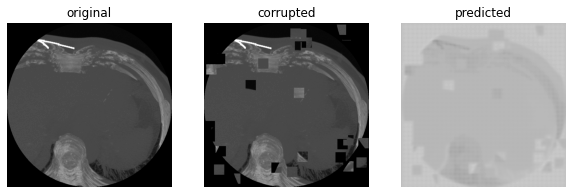

Epoch 2/10000
51/51 [==============================] - 14s 271ms/step - loss: 0.2962 - val_loss: 0.0242
Epoch 3/10000
51/51 [==============================] - 14s 272ms/step - loss: 0.0191 - val_loss: 0.0163
Epoch 4/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0148 - val_loss: 0.0136
Epoch 5/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0125 - val_loss: 0.0116
Epoch 6/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0108 - val_loss: 0.0101


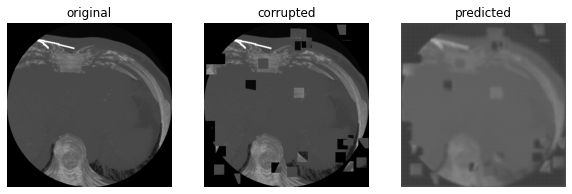

Epoch 7/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0095 - val_loss: 0.0090
Epoch 8/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0085 - val_loss: 0.0082
Epoch 9/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 10/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 11/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0069 - val_loss: 0.0067


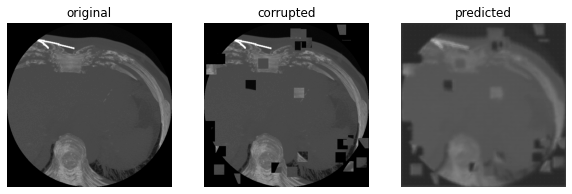

Epoch 12/10000
51/51 [==============================] - 14s 272ms/step - loss: 0.0065 - val_loss: 0.0064
Epoch 13/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0062 - val_loss: 0.0062
Epoch 14/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0060 - val_loss: 0.0059
Epoch 15/10000
51/51 [==============================] - 14s 272ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 16/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0056 - val_loss: 0.0057


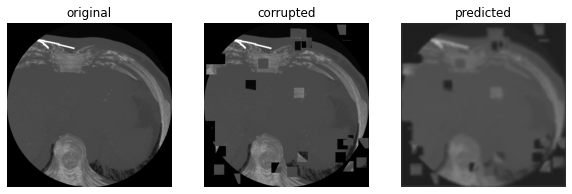

Epoch 17/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 18/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0054 - val_loss: 0.0054
Epoch 19/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 20/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 21/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0051 - val_loss: 0.0051


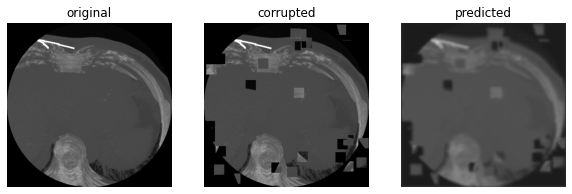

Epoch 22/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 23/10000
51/51 [==============================] - 14s 272ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 24/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 25/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 26/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0047 - val_loss: 0.0047


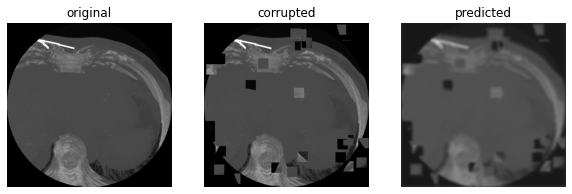

Epoch 27/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 28/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 29/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0045 - val_loss: 0.0046
Epoch 30/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 31/10000
51/51 [==============================] - 14s 276ms/step - loss: 0.0045 - val_loss: 0.0044


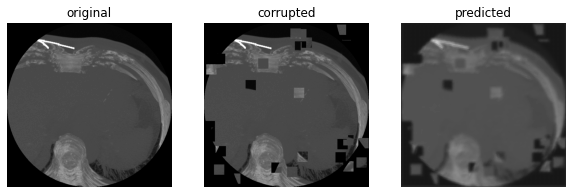

Epoch 32/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 33/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 34/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 35/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 36/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0043 - val_loss: 0.0043


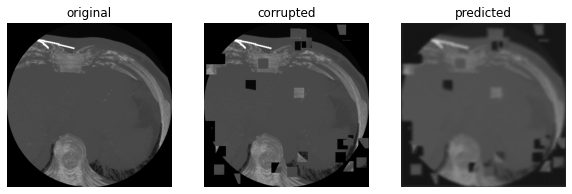

Epoch 37/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 38/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 39/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 40/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 41/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0041 - val_loss: 0.0041


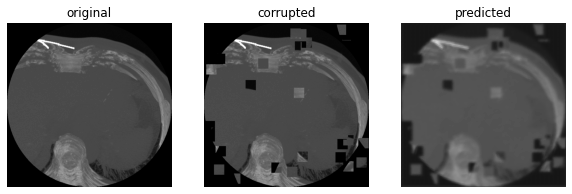

Epoch 42/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 43/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 44/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 45/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 46/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0040 - val_loss: 0.0040


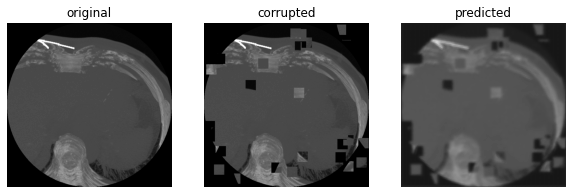

Epoch 47/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 48/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 49/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 50/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 51/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0039 - val_loss: 0.0039


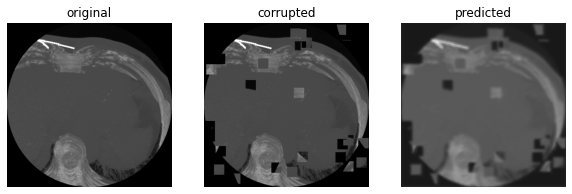

Epoch 52/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 53/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 54/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 55/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 56/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0039 - val_loss: 0.0039


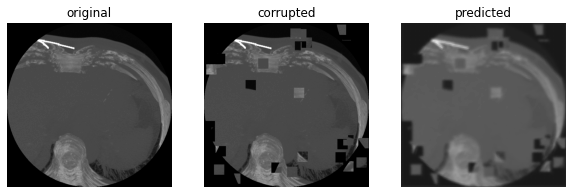

Epoch 57/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 58/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 59/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 60/10000
51/51 [==============================] - 14s 272ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 61/10000
51/51 [==============================] - 14s 272ms/step - loss: 0.0038 - val_loss: 0.0038


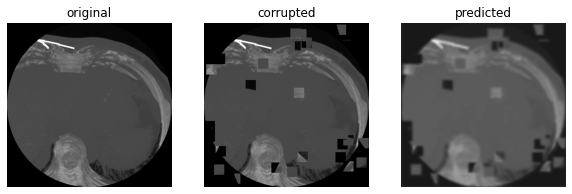

Epoch 62/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 63/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 64/10000
51/51 [==============================] - 14s 272ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 65/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 66/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0038 - val_loss: 0.0038


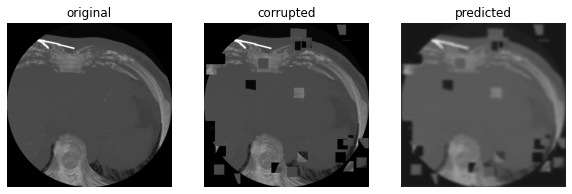

Epoch 67/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 68/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 69/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 70/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 71/10000
51/51 [==============================] - 14s 274ms/step - loss: 0.0037 - val_loss: 0.0037


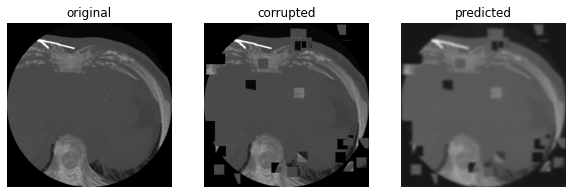

Epoch 72/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 73/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 74/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 75/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 76/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0037 - val_loss: 0.0037


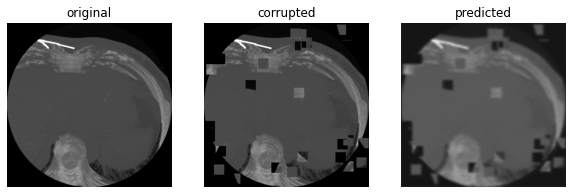

Epoch 77/10000
51/51 [==============================] - 14s 276ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 78/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 79/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 80/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 81/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0037 - val_loss: 0.0037


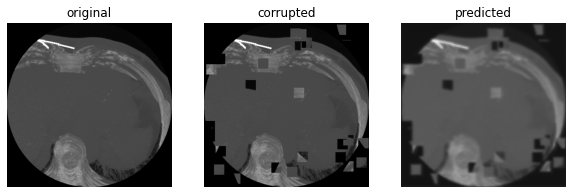

Epoch 82/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 83/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 84/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 85/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 86/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0036 - val_loss: 0.0036


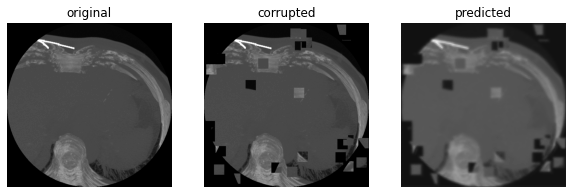

Epoch 87/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 88/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 89/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 90/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 91/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0036 - val_loss: 0.0036


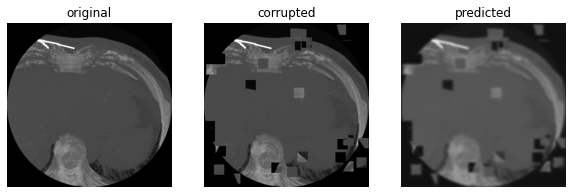

Epoch 92/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 93/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 94/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 95/10000
51/51 [==============================] - 14s 274ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 96/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0036 - val_loss: 0.0036


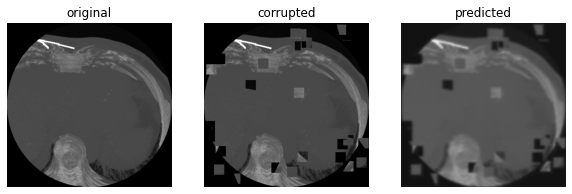

Epoch 97/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 98/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 99/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 100/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 101/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0036 - val_loss: 0.0036


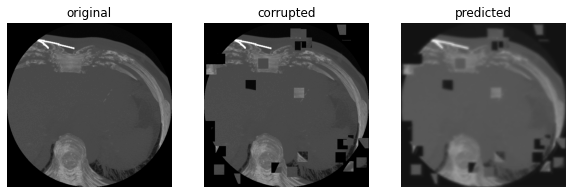

Epoch 102/10000
51/51 [==============================] - 14s 274ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 103/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 104/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 105/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 106/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0035 - val_loss: 0.0035


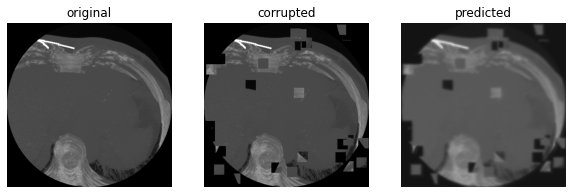

Epoch 107/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 108/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 109/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 110/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 111/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0035 - val_loss: 0.0035


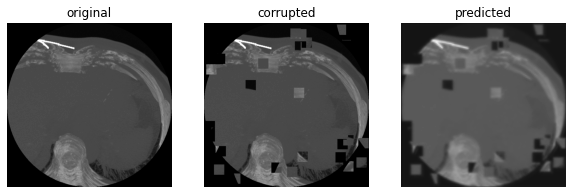

Epoch 112/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 113/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 114/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 115/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 116/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0035 - val_loss: 0.0035


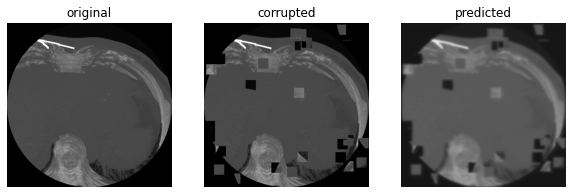

Epoch 117/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 118/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 119/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 120/10000
51/51 [==============================] - 14s 274ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 121/10000
51/51 [==============================] - 14s 274ms/step - loss: 0.0035 - val_loss: 0.0035


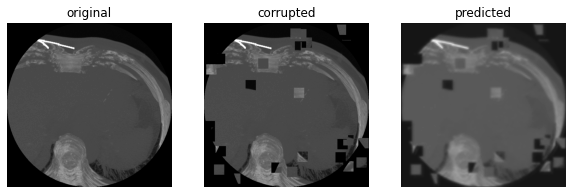

Epoch 122/10000
51/51 [==============================] - 14s 272ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 123/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 124/10000
51/51 [==============================] - 14s 274ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 125/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 126/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0036 - val_loss: 0.0035


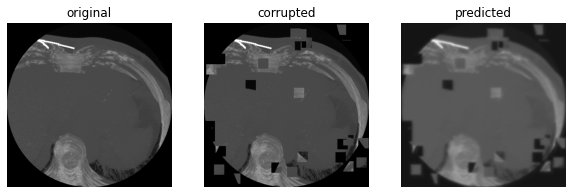

Epoch 127/10000
51/51 [==============================] - 14s 277ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 128/10000
51/51 [==============================] - 14s 272ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 129/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 130/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 131/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0035 - val_loss: 0.0035


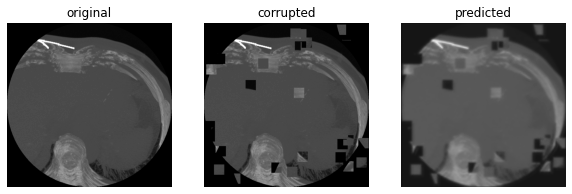

Epoch 132/10000
51/51 [==============================] - 14s 272ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 133/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 134/10000
51/51 [==============================] - 14s 272ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 135/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 136/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0038 - val_loss: 0.0042


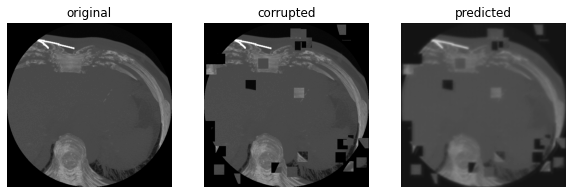

Epoch 137/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 138/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 139/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 140/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 141/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0034 - val_loss: 0.0035


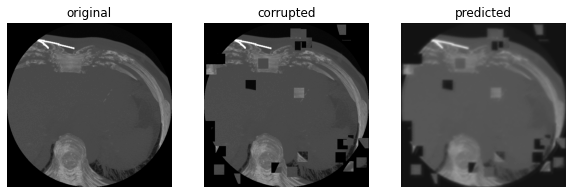

Epoch 142/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 143/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 144/10000
51/51 [==============================] - 14s 274ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 145/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 146/10000
51/51 [==============================] - 14s 274ms/step - loss: 0.0034 - val_loss: 0.0035


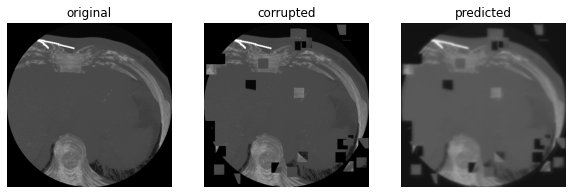

Epoch 147/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 148/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 149/10000
51/51 [==============================] - 14s 274ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 150/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 151/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0034 - val_loss: 0.0034


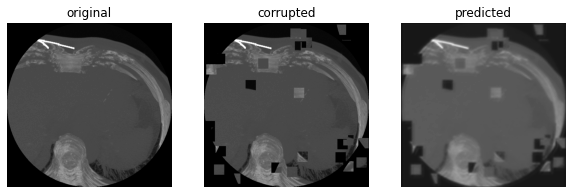

Epoch 152/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 153/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 154/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 155/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 156/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0034 - val_loss: 0.0036


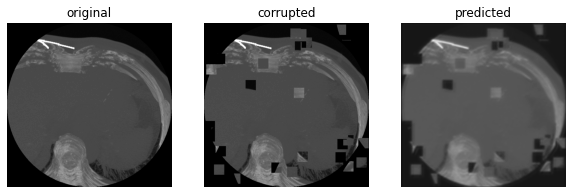

Epoch 157/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 158/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 159/10000
51/51 [==============================] - 14s 274ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 160/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 161/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0034 - val_loss: 0.0034


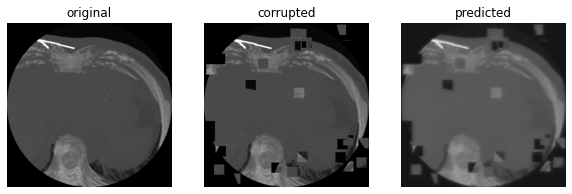

Epoch 162/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 163/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 164/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 165/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 166/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0034 - val_loss: 0.0033


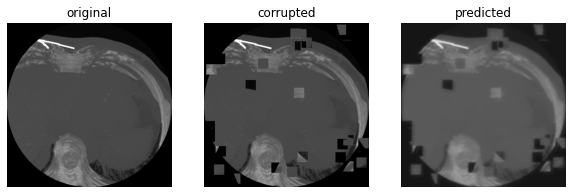

Epoch 167/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 168/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 169/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 170/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 171/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0034 - val_loss: 0.0033


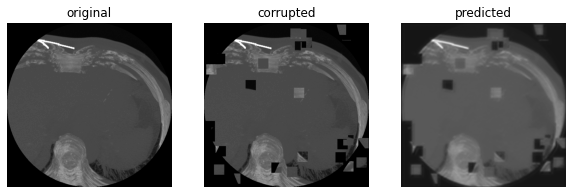

Epoch 172/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 173/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 174/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 175/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0034 - val_loss: 0.0039
Epoch 176/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0035 - val_loss: 0.0033


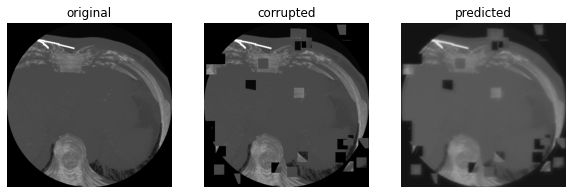

Epoch 177/10000
51/51 [==============================] - 14s 276ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 178/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 179/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 180/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 181/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0033 - val_loss: 0.0035


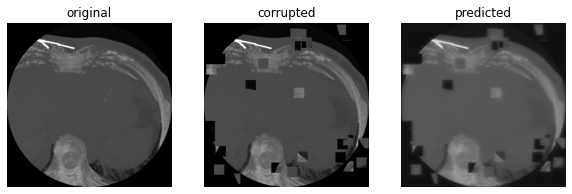

Epoch 182/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 183/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 184/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 185/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 186/10000
51/51 [==============================] - 14s 272ms/step - loss: 0.0033 - val_loss: 0.0032


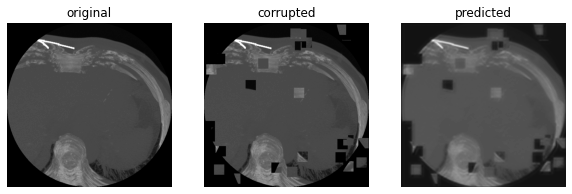

Epoch 187/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 188/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 189/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 190/10000
51/51 [==============================] - 14s 274ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 191/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0032 - val_loss: 0.0033


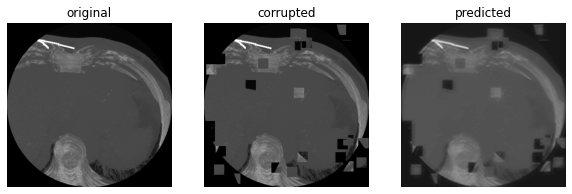

Epoch 192/10000
51/51 [==============================] - 14s 272ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 193/10000
51/51 [==============================] - 14s 272ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 194/10000
51/51 [==============================] - 14s 272ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 195/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 196/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0033 - val_loss: 0.0032


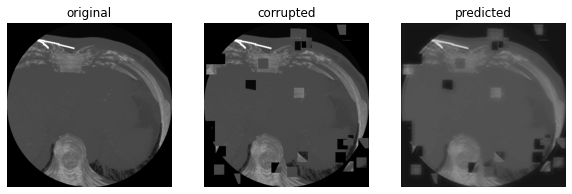

Epoch 197/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 198/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 199/10000
51/51 [==============================] - 14s 272ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 200/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 201/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0032 - val_loss: 0.0032


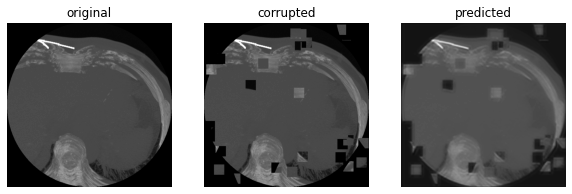

Epoch 202/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 203/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 204/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 205/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 206/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0033 - val_loss: 0.0033


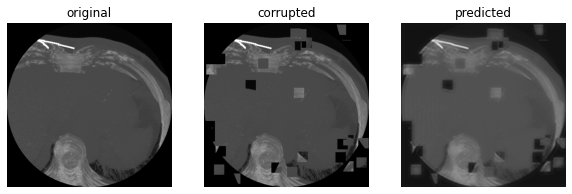

Epoch 207/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 208/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 209/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 210/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 211/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0032 - val_loss: 0.0031


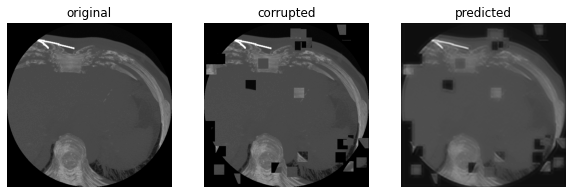

Epoch 212/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 213/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 214/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 215/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 216/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0032 - val_loss: 0.0032


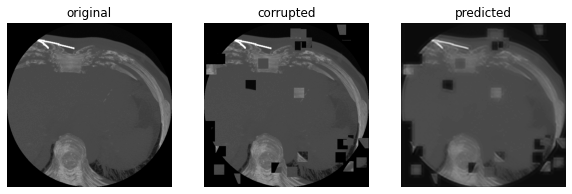

Epoch 217/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 218/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 219/10000
51/51 [==============================] - 14s 274ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 220/10000
51/51 [==============================] - 14s 274ms/step - loss: 0.0032 - val_loss: 0.0038
Epoch 221/10000
51/51 [==============================] - 14s 274ms/step - loss: 0.0032 - val_loss: 0.0032


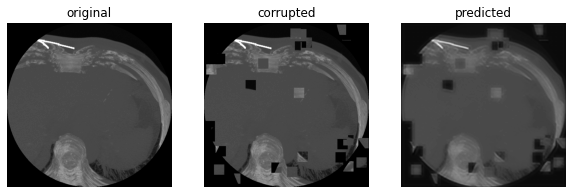

Epoch 222/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 223/10000
51/51 [==============================] - 14s 274ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 224/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 225/10000
51/51 [==============================] - 14s 274ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 226/10000
51/51 [==============================] - 14s 274ms/step - loss: 0.0031 - val_loss: 0.0031


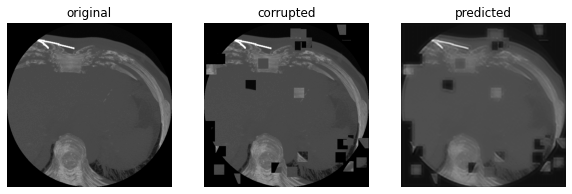

Epoch 227/10000
51/51 [==============================] - 14s 276ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 228/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 229/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 230/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 231/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0031 - val_loss: 0.0030


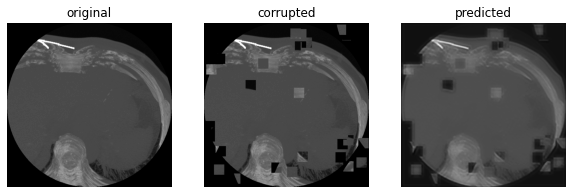

Epoch 232/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 233/10000
51/51 [==============================] - 14s 274ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 234/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 235/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 236/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0031 - val_loss: 0.0030


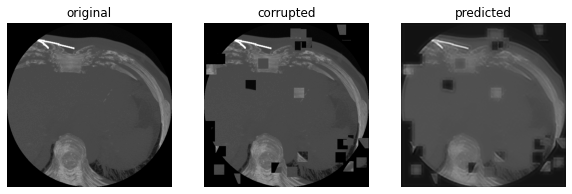

Epoch 237/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 238/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 239/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 240/10000
51/51 [==============================] - 14s 274ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 241/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0030 - val_loss: 0.0030


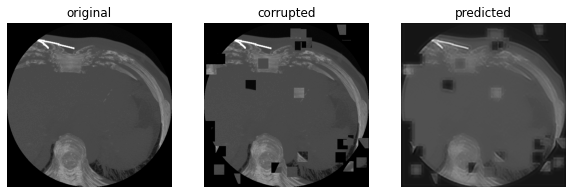

Epoch 242/10000
51/51 [==============================] - 14s 274ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 243/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 244/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 245/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 246/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0030 - val_loss: 0.0030


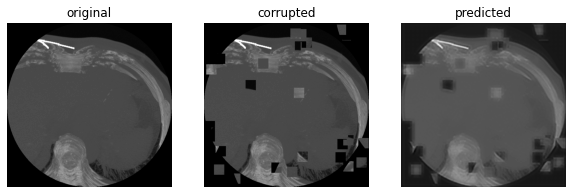

Epoch 247/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 248/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 249/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 250/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 251/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0028 - val_loss: 0.0029


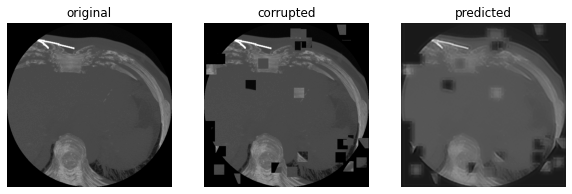

Epoch 252/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 253/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 254/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 255/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 256/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0028 - val_loss: 0.0028


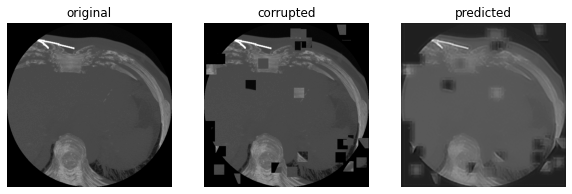

Epoch 257/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 258/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 259/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 260/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 261/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0027 - val_loss: 0.0027


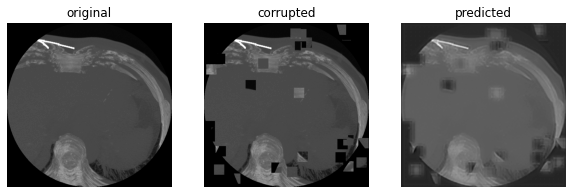

Epoch 262/10000
51/51 [==============================] - 14s 272ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 263/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 264/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 265/10000
51/51 [==============================] - 14s 273ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 266/10000
24/51 [=============>................] - ETA: 6s - loss: 0.0026

In [ ]:
history = model.fit(X_train, y_train, epochs=10000, batch_size=8, validation_data=(X_test, y_test), callbacks=custom_callbacks)

In [ ]:
historyName = 'models/history_' + MODEL_NAME
modelName = 'models/' + MODEL_NAME

model.save(modelName)
with open(historyName, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

## Evaluation

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
exclude=['models/groot_model_LR_0.002_/image.png','models/groot_model_LR_0.002_/image_corrupt.png']
reconstructed = glob('models/groot_model_LR_0.002_/*.png')
reconstructed = [r for r in reconstructed if r not in exclude]
reconstructed.sort()

images = []
for image_path in reconstructed:
    im = plt.imread(image_path)
    images.append(plt.imread(image_path))
images = np.array(images)
reconstructed

In [ ]:
%%time

Figure = plt.figure()
 
# creating a plot
lines_plotted = plt.imshow(images[0], cmap=plt.cm.gray)    

# function takes frame as an input
def AnimationFunction(frame):
 
    # setting y according to frame
    # number and + x. It's logic
    plt.imshow(images[frame], cmap=plt.cm.gray)
     
anim = FuncAnimation(Figure, AnimationFunction, frames=images.shape[0], interval=100)

writervideo = animation.FFMpegWriter(fps=10)
# anim.save('videos/TrainingsVideo.mp4', writervideo)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)

plt.close()